In [107]:
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
from yahooquery import Ticker

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS

In [108]:
#importando base
df_ibrx = pd.read_excel('/Users/user/Desktop/Empresa/Pairs Strategy.xlsx', sheet_name = 'Possible Pair')
df_ibrx.head()

,Código,Ação,Tipo,Qtde. Teórica,Part. (%),Setor,Subsetor,Segmento
0,BBAS3,BRASIL,ON NM,1.418.466.803,2393.0,Financeiro,Intermediários Financeiros,Gás
1,BBDC3,BRADESCO,ON N1,1.253.093.907,1253.0,Financeiro,Intermediários Financeiros,Gás
2,BBDC4,BRADESCO,PN N1,4.261.649.634,4600.0,Financeiro,Intermediários Financeiros,Gás
3,BBSE3,BBSEGURIDADE,ON ED NM,671.601.167,923.0,Financeiro,Previdência e Seguros,Seguradoras
4,BIDI11,BANCO INTER,UNT N2,133.605.928,405.0,Financeiro,Intermediários Financeiros,Gás


In [109]:
# dando aquele tapa
df = df_ibrx
df = pd.DataFrame(df) 
df = df.dropna()
df['Part. (%)'] /= 100000
df.rename(columns={'Código\xa0':'Codigo'}, inplace = True)
df['Codigo'] = df['Codigo'] + ".SA"
tickers = df['Codigo']

In [110]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))

    return pd.DataFrame(pairs)

In [111]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [112]:
def zscore_spread(x,y):
    #x = S1
    #y = S2
    rolling_beta = RollingOLS(x,y, window = 30)
    rres = rolling_beta.fit()
    params = rres.params
    b_rolling = params.dropna()

    spread_2 = y - b_rolling.T * x
    spread_3 = pd.DataFrame()
    spread_3 = spread_2.T
    spread_3.name = 'spread'

    # 1 day MAVG spread
    spread_mavg1 = spread_3.rolling(1).mean()
    spread_mavg1.name = 'spread 1d mavg'

    # 30 day MAVG spread
    spread_mavg30 = spread_3.rolling(30).mean()
    spread_mavg30.name = 'spread 30d mavg'
    
    std_30 = spread_3.rolling(30).std()
    std_30.name = 'std 30d'

    # z-score para cada dia
    zscore_30 = (spread_mavg1 - spread_mavg30)/std_30
    zscore_30.name = 'z-score'
    
    return zscore_30

In [113]:
def trade_signal_S1(x,sigma_entrada, sigma_saida):
    #x = df_trades
    #sigma_entrada = std devs (sigmas) pra entrar na posicao
    #sigma_saida = std devs (sigmas) pra sair da posicao
    
    df = copy.deepcopy(x)
    
    df_trade_signal_S1 = pd.DataFrame(columns=['Date', 'Z Score','Signal S1'])
    df_trade_signal_S1['Z Score'] = df['Z Score'].iloc[:,-1]

    for j in range(len(df_trade_signal_S1['Z Score'])):
        if df_trade_signal_S1['Z Score'].iloc[j] > sigma_entrada:
            #print ('Short Spread: short S2 and long S1')
            df_trade_signal_S1['Signal S1'][j] = 'Long'
            
        elif df_trade_signal_S1['Signal S1'].iloc[j-1] == 'Long'and \
        df_trade_signal_S1['Z Score'].iloc[j] > sigma_saida:
            
            df_trade_signal_S1['Signal S1'][j] = 'Long'

        elif df_trade_signal_S1['Signal S1'].iloc[j-1] == 'Long'and \
        df_trade_signal_S1['Z Score'].iloc[j] <= sigma_saida:
            
            df_trade_signal_S1['Signal S1'][j] = 'Exit position'
        
        elif df_trade_signal_S1['Z Score'].iloc[j] < -sigma_entrada:
            #print ('Long Spread: long S2 and short S1')
            df_trade_signal_S1['Signal S1'][j] = 'Short'  
        
        elif df_trade_signal_S1['Signal S1'].iloc[j-1] == 'Short'and \
        df_trade_signal_S1['Z Score'].iloc[j] < -sigma_saida:
            
            df_trade_signal_S1['Signal S1'][j] = 'Short'     
        
        elif df_trade_signal_S1['Signal S1'].iloc[j-1] == 'Short'and \
        df_trade_signal_S1['Z Score'].iloc[j] >= -sigma_saida:
            
            df_trade_signal_S1['Signal S1'][j] = 'Exit position'
            
        else:
            df_trade_signal_S1['Signal S1'][j] = ''
            
    return df_trade_signal_S1['Signal S1']

In [114]:
def trade_signal_S2(x,sigma_entrada, sigma_saida):
    #x = df_trades
    #sigma_entrada = std devs (sigmas) pra entrar na posicao
    #sigma_saida = std devs (sigmas) pra sair da posicao
    
    df = copy.deepcopy(x)
    
    df_trade_signal_S2 = pd.DataFrame(columns=['Date', 'Z Score','Signal S2'])
    df_trade_signal_S2['Z Score'] = df['Z Score'].iloc[:,-1]

    for j in range(len(df_trade_signal_S2['Z Score'])):
        if df_trade_signal_S2['Z Score'].iloc[j] > sigma_entrada:
            #print ('Short Spread: short S2 and long S1')
            df_trade_signal_S2['Signal S2'][j] = 'Short'
            
        elif df_trade_signal_S2['Signal S2'].iloc[j-1] == 'Short'and \
        df_trade_signal_S2['Z Score'].iloc[j] > sigma_saida:
            
            df_trade_signal_S2['Signal S2'][j] = 'Short'

        elif df_trade_signal_S2['Signal S2'].iloc[j-1] == 'Short'and \
        df_trade_signal_S2['Z Score'].iloc[j] <= sigma_saida:
            
            df_trade_signal_S2['Signal S2'][j] = 'Exit position'
        
        elif df_trade_signal_S2['Z Score'].iloc[j] < -sigma_entrada:
            #print ('Long Spread: long S2 and short S1')
            df_trade_signal_S2['Signal S2'][j] = 'Long'  
        
        elif df_trade_signal_S2['Signal S2'].iloc[j-1] == 'Long'and \
        df_trade_signal_S2['Z Score'].iloc[j] < -sigma_saida:
            
            df_trade_signal_S2['Signal S2'][j] = 'Long'     
        
        elif df_trade_signal_S2['Signal S2'].iloc[j-1] == 'Long'and \
        df_trade_signal_S2['Z Score'].iloc[j] >= -sigma_saida:
            
            df_trade_signal_S2['Signal S2'][j] = 'Exit position'
            
        else:
            df_trade_signal_S2['Signal S2'][j] = ''
            
    return df_trade_signal_S2['Signal S2']

In [115]:
def return_S1(x):
    #x = df_trades
    
    df = copy.deepcopy(x)
    
    df_trade_return_S1 = pd.DataFrame(columns=['Date','S1 price','Trade Signal S1', 'Return S1'])
    df_trade_return_S1['S1 price'] = df['S1 price']
    df_trade_return_S1['Trade Signal S1'] = df['Trade Signal S1']
   
    for j in range(len(df_trade_return_S1)):
        if df_trade_return_S1['Trade Signal S1'].iloc[j-1] == 'Long':
            df_trade_return_S1['Return S1'][j] = df_trade_return_S1['S1 price'][j]/df_trade_return_S1['S1 price'][j-1]-1
            
        elif df_trade_return_S1['Trade Signal S1'].iloc[j-1] == 'Short':
            df_trade_return_S1['Return S1'][j] = df_trade_return_S1['S1 price'][j-1]/df_trade_return_S1['S1 price'][j]-1
        
        else:
            df_trade_return_S1['Return S1'][j]=0
    
    df_trade_return_S1['Return S1'].iloc[0] = 0
    
    return df_trade_return_S1['Return S1']

In [116]:
def return_S2(x):
    #x = df_trades
    
    df = copy.deepcopy(x)
    
    df_trade_return_S2 = pd.DataFrame(columns=['Date','S2 price','Trade Signal S2', 'Return S2'])
    df_trade_return_S2['S2 price'] = df['S2 price']
    df_trade_return_S2['Trade Signal S2'] = df['Trade Signal S2']
   
    for j in range(len(df_trade_return_S2)):
        if df_trade_return_S2['Trade Signal S2'].iloc[j-1] == 'Long':
            df_trade_return_S2['Return S2'][j] = df_trade_return_S2['S2 price'][j]/df_trade_return_S2['S2 price'][j-1]-1
            
        elif df_trade_return_S2['Trade Signal S2'].iloc[j-1] == 'Short':
            df_trade_return_S2['Return S2'][j] = df_trade_return_S2['S2 price'][j-1]/df_trade_return_S2['S2 price'][j]-1
        
        else:
            df_trade_return_S2['Return S2'][j]=0
    
    df_trade_return_S2['Return S2'].iloc[0] = 0
    
    return df_trade_return_S2['Return S2']

In [117]:
start = dt.date.today() + dt.timedelta(1) - dt.timedelta(360)
end = dt.date.today() + dt.timedelta(1)
prices = {}
interval = '1d' #1d para diario, 5m para 5minutos
for t in tickers:
    try:
        prices[t] = yf.download(t,start,end,interval)
    except: 
        continue
    prices[t].dropna(how='all', inplace = True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [118]:
tickers2 = tickers.drop([4,5]) #tira BPAC e BIDI que tiveram IPOs recentes

In [141]:
tickers_list = tickers2.to_list()

#df_prices
data = yf.download(tickers_list,start,end,interval)['Close']

df_prices = pd.DataFrame()
df_prices = data
df_prices.dropna(how='all', inplace = True)

#df_pvalue
start_2 = dt.date.today() + dt.timedelta(1) - dt.timedelta(360)
end_2 = dt.date.today() + dt.timedelta(1) - dt.timedelta(180)

pvalue_prices = yf.download(tickers_list,start_2,end_2,interval)['Close']

df_pvalue = pd.DataFrame()
df_pvalue = pvalue_prices
df_pvalue.dropna(how='all', inplace = True)

#df_prices_2
start_3 =  dt.date.today() + dt.timedelta(1) - dt.timedelta(215)
end_3 = dt.date.today() + dt.timedelta(1)

stocks_prices = yf.download(tickers_list,start_3,end_3,interval)['Close']

df_prices_2 = pd.DataFrame()
df_prices_2 = stocks_prices
df_prices_2.dropna(how='all', inplace = True)

#fazer um df prices com end = today, start = end2

df_prices, df_pvalue, df_prices_2

[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed


(             BBAS3.SA   BBDC3.SA   BBDC4.SA   BBSE3.SA  BPAN4.SA   BRSR6.SA  \
 Date                                                                          
 2019-10-11  45.230000  31.400000  34.009998  34.259998      7.77  21.790001   
 2019-10-14  45.000000  31.860001  34.490002  34.259998      7.85  21.870001   
 2019-10-15  44.380001  32.169998  34.770000  34.410000      7.80  21.750000   
 2019-10-16  45.000000  33.150002  35.599998  34.889999      7.65  22.010000   
 2019-10-17  44.910000  32.689999  35.000000  35.070000      8.43  22.059999   
 ...               ...        ...        ...        ...       ...        ...   
 2020-09-28  30.510000  18.219999  19.719999  24.250000      8.12  12.100000   
 2020-09-29  29.760000  17.889999  19.250000  24.450001      7.93  11.750000   
 2020-09-30  29.620001  18.020000  19.410000  24.270000      8.12  11.930000   
 2020-10-01  29.790001  18.049999  19.500000  24.610001      8.33  11.900000   
 2020-10-02  29.709999  18.120001  19.63

In [120]:
pairs_x = find_cointegrated_pairs(df_pvalue)
pairs_x2 =pd.DataFrame()
pairs_x2['S1'] = pairs_x.iloc[:,0] 
pairs_x2['S2'] = pairs_x.iloc[:,1]

In [121]:
portfolio_pairs = pairs_x2.to_dict()
portfolio_pairs

{'S1': {0: 'BBDC3.SA',
  1: 'BBDC4.SA',
  2: 'BBDC4.SA',
  3: 'BRSR6.SA',
  4: 'BRSR6.SA'},
 'S2': {0: 'BBSE3.SA',
  1: 'BBSE3.SA',
  2: 'ITSA4.SA',
  3: 'ITSA4.SA',
  4: 'SANB11.SA'}}

In [122]:
portfolio_pairs_x2 = pairs_x2.T.to_dict()
portfolio_pairs_x2

{0: {'S1': 'BBDC3.SA', 'S2': 'BBSE3.SA'},
 1: {'S1': 'BBDC4.SA', 'S2': 'BBSE3.SA'},
 2: {'S1': 'BBDC4.SA', 'S2': 'ITSA4.SA'},
 3: {'S1': 'BRSR6.SA', 'S2': 'ITSA4.SA'},
 4: {'S1': 'BRSR6.SA', 'S2': 'SANB11.SA'}}

In [138]:
df_trades = copy.deepcopy(portfolio_pairs_x2)
#df_trades = pd.DataFrame(columns =['Date','S1 price', 'S2 price', 'Z Score', 'Trade Signal S1','Trade Signal S2', \
                                  #'Return S1','Return S2','Return Total'])

for i in portfolio_pairs_x2.keys():
    df_trades[i]['S1 price'] = df_prices[portfolio_pairs['S1'][i]]
    df_trades[i]['S2 price'] = df_prices[portfolio_pairs['S2'][i]]
    df_trades[i]['Z Score'] = zscore_spread(df_trades[i]['S1 price'],df_trades[i]['S2 price'])
    df_trades[i]['Trade Signal S1'] = trade_signal_S1(df_trades[i],1.5,0.5) #quebrar em outro bloco?
    df_trades[i]['Trade Signal S2'] = trade_signal_S2(df_trades[i],1.5,0.5) #a funcao trade signal precisa do Z Score
    df_trades[i]['Return S1'] = return_S1(df_trades[i]) #quebrar em outro bloco de novo?
    df_trades[i]['Return S2'] = return_S2(df_trades[i]) #usa trade signal e price
    df_trades[i]['Return Total'] = (df_trades[i]['Return S1'] + df_trades[i]['Return S2'])/2
    df_trades[i]['Return Total'].iloc[0] = 1

/Users/user/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/user/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/user/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/user/opt/anaconda3/lib/python3.7/site-packages/ipykernel_

In [149]:
Return_portfolio = 0
for i in df_trades:
    Return_portfolio += pd.DataFrame(df_trades[i]['Return Total'])

In [96]:
Return_portfolio_2 = Return_portfolio/len(df_trades.keys())

In [150]:
Return_portfolio_3 = (1+Return_portfolio_2).cumprod()-1
Return_portfolio_3

,0
Date,
2019-10-11,1
2019-10-14,1
2019-10-15,1
2019-10-16,1
2019-10-17,1
...,...
2020-09-28,1.50256
2020-09-29,1.51272
2020-09-30,1.51222


In [98]:
start_BOVA11 = start
price_BOVA11 = {}
try:
    price_BOVA11 = yf.download('BOVA11.SA',start_BOVA11,end,interval='1d')  
except: 
    print('Erro no BOVA11')
    pass
price_BOVA11.dropna(how='all', inplace = True)

[*********************100%***********************]  1 of 1 completed


In [99]:
price_BOVA11['Ret'] = price_BOVA11['Adj Close'].pct_change()

In [100]:
price_BOVA11.drop(price_BOVA11.index[0], inplace=True)

In [101]:
BOVA11_ret_acum = (1+price_BOVA11['Ret']).cumprod()

In [102]:
BOVA11_ret_acum2 = ((price_BOVA11['Ret']+1).loc[start:end]).cumprod()

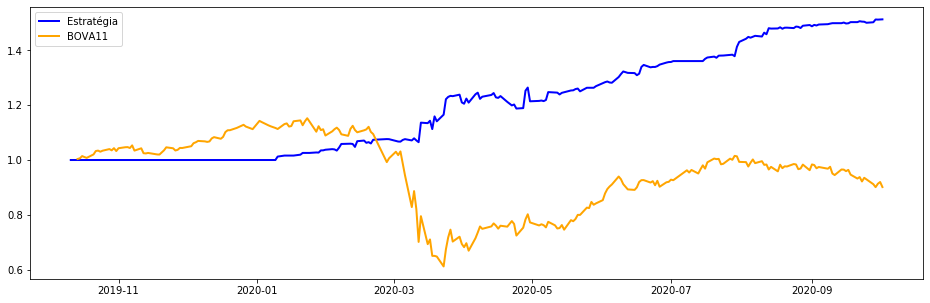

In [103]:
#sigma 1.5 e -0.5 --> df_pvalue
#fazer o merge de datas, cada dftrades só tem uma coluna de data
#variavel pra ativar o trade, um if data > data que eu quero, mando o trade signal rodar, else vazio
#retorno de cada par no grafico
#grafico com o PL utilizado
#contador de trade
plt.figure(figsize=(16,5))
plt.plot(Return_portfolio_3, marker='', color='blue', linewidth=2, label="Estratégia")
plt.plot(BOVA11_ret_acum, marker='', color='orange', linewidth=2, label="BOVA11")
plt.legend()